# **End-to-End Workflow for House Price Prediction Using Machine Learning**

In [ ]:
from IPython.display import HTML

html_code = '''
<iframe
    src="https://rmhalak-house-pricing-v1.hf.space/"
    frameborder="0"
    width="1200"
    height="750"
></iframe>
'''

display(HTML(html_code))

# Summary


This notebook demonstrates the end-to-end process of building, training, and deploying a machine learning model (fully-connected neural network) for predicting house prices. Here's a summary of the steps covered:

1. **Load Data from Kaggle**
   - The dataset is loaded into a Pandas DataFrame from a CSV file provided via Kaggle.

2. **Import Libraries**
   - Essential libraries are imported, including TensorFlow for building the model, Pandas and NumPy for data manipulation, and Matplotlib for visualization.

3. **Preprocessing and Feature Generation**
   - The dataset is preprocessed by dropping irrelevant columns, filtering out non-positive prices, and converting date columns.
   - New features are created, such as `house_age` and `years_since_renovation`.
   - Numerical features are bucketized and normalized.
   - Categorical features are transformed into numerical format using one-hot encoding.

4. **Generate Train and Test Sets**
   - The dataset is split into training and testing sets using an 80/20 split.

5. **Create the Model**
   - A Sequential neural network model is defined with dense layers for regression tasks.
   - The model is compiled with the Adam optimizer and Mean Squared Error loss function.
   - An early stopping callback is used to prevent overfitting and restore the best weights.

6. **Training**
   - The model is trained on the training data for up to 1000 epochs with early stopping in place.
   - A validation split is used to monitor performance during training.

7. **Export the Trained Model**
   - The trained model is saved to a file using `pickle`, allowing for future use without retraining.

8. **Load the Trained Model**
   - The saved model is loaded from the file for making predictions.

9. **Prediction of a New Data Point using Trained Model**
   - A new data point is prepared, processed, and used to make a prediction with the trained model.

10. **Create a Web Application Based on the Trained Model**
   - Deploy the trained model as a web application, allowing users to interact with it and make predictions via a user-friendly interface. This is implemented by:
      * 10.1. Developing a web application using simple web interface frameworks like `streamlit`. This interface will allow users to input features such as bedrooms and bathrooms, and then use the trained model to predict house prices.
      * 10.2. Deploying the application by hosting it on a cloud service such as Hugging Face Spaces or AWS. This makes the model accessible via a web browser.


# Load data from Kaggle

It is possible to download datasets directly from Kaggle to your local environment or cloud storage using the Kaggle command-line tool or the Python kaggle package. This step typically involves specifying the dataset name and running the download command. Once the data is downloaded, it can be loaded for further processing and analysis.

In [ ]:
!kaggle datasets download -d shree1992/housedata

Dataset URL: https://www.kaggle.com/datasets/shree1992/housedata
License(s): unknown
  0% 0.00/432k [00:00<?, ?B/s]
100% 432k/432k [00:00<00:00, 28.2MB/s]


In [ ]:
!unzip '/content/housedata.zip'

Archive:  /content/housedata.zip
  inflating: data.csv                
  inflating: data.dat                
  inflating: output.csv              


# Import libraries

Next. the necessary libraries and packages are imported to facilitate data handling, machine learning, and model development.

* `pandas` and `numpy` are used for data manipulation and numerical operations.
* `tensorflow` is the core library used for building and training deep learning models, specifically using the Keras API for constructing neural networks.
* `os` is used for interacting with the operating system, such as setting environment variables.
* `pickle` and `json` are utilized for saving and loading serialized data structures.
* `matplotlib.pyplot` is employed for creating visualizations, particularly for plotting data distributions and model performance.
* `train_test_split` function from `sklearn.model_selection` is included to split the dataset into training and testing subsets. Additionally, a seed value of 42 is set to ensure reproducibility, meaning that the code will yield the same results each time it is run. Setting the `TF_DETERMINISTIC_OPS` environment variable ensures that TensorFlow operations behave deterministically, further contributing to consistent results across runs.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import pickle
import json
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Set seeds for reproducibility
tf.random.set_seed(42)

# Ensure reproducibility by configuring deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Read the Data

In [ ]:
# the dataset is loaded into a Pandas DataFrame from a CSV file.
df = pd.read_csv('/content/data.csv')

# Preprocess the Data

Data preprocessing begins by creating a copy of the original DataFrame.
* Because this dataset concerns data taken only from Washington (USA), we drop irrelevant columns such as `country`, `street`, and `statezip`.
* Rows with null or non-positive `price` are filtered out.
* The `date` column is converted to a datetime object
* The numeric columns like `bedrooms`, `bathrooms`, and `floors` are converted to integers for consistency

In [ ]:
# preprocessing
df_features = df.copy()
df_features = df_features.drop(columns=['country', 'street', 'statezip'])
df_features = df_features[df_features['price'] > 0]
df_features['date'] = pd.to_datetime(df_features['date'])
for col in ['bedrooms', 'bathrooms', 'floors']:
    df_features[col] = df_features[col].apply(lambda x:int(x))

# Generate Features

New features are generated to enrich the dataset. These include `house_age` (calculated as the difference between the year sold and the year built) and `years_since_renovation` (calculated similarly but considering renovations). A binary `has_basement` feature is created based on whether the house has a basement. Houses that haven't been renovated have their `yr_renovated` set to the year they were built.



In [ ]:
def create_new_features(df):
    df['year_sold'] = df['date'].dt.year
    df = df.drop(columns=['date'])
    df['house_age'] = df['year_sold'] - df['yr_built']
    df['years_since_renovation'] = df['year_sold'] - df['yr_renovated']
    df.drop(columns=['year_sold'], inplace=True)
    df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
    mask = df['yr_renovated'] == 0
    df.loc[mask, 'yr_renovated'] = df.loc[mask, 'yr_built']
    return df

df_features = create_new_features(df_features)

# Bucketize Numerical Features

To simplify numerical features, bucketization is performed. For certain columns (e.g., `sqft_living`, `sqft_lot`), values are grouped into buckets of a specified size, making the data less granular and potentially more useful for our model.

In [ ]:
bucket_sizes = {'sqft_living': 25,
                'sqft_lot': 25,
                'sqft_above': 25,
                'sqft_basement': 25}

def bucketize(df, col, size):
    return df[col].apply(lambda x: (x // size)*size)

for col, size in bucket_sizes.items():
    df_features[col] = bucketize(df_features, col, size)

# Normalize Numerical Features

Normalization is applied to numerical features to scale them between 0 and 1, making the features comparable in magnitude and improving the performance of machine learning models. This is done using the minimum and maximum values of each numerical feature.

In [ ]:
numerical_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',
                      'view', 'condition', 'sqft_above', 'sqft_basement',
                      'yr_built', 'yr_renovated', 'house_age', 'years_since_renovation']

min_dict = dict(df_features[numerical_features].min())
max_dict = dict(df_features[numerical_features].max())

def normalize(df, col):
    df[col] = df[col].apply(lambda x: (x-min_dict[col])/(max_dict[col]-min_dict[col]))
    return df[col]

for col in numerical_features:
    df_features[col] = normalize(df_features, col)

# Generate Categorical Features

Categorical features, such as `city`, are transformed into numerical features through one-hot encoding, where each unique category is converted into a new binary column. This process is essential for integrating categorical data into machine learning models that require numerical inputs.

In [ ]:
cat_features = ['city']
for col in cat_features:
    dummies = pd.get_dummies(df_features[col], prefix=col).apply(lambda x: x.astype(int))
    df_features = pd.concat([df_features, dummies], axis=1)
    df_features.drop(columns=[col], inplace=True)

# Generate Train and Test Sets

In this step, the dataset is split into features `X` and target variable `y`. The target variable is price, which is separated from the rest of the features in the DataFrame.

The dataset is then divided into training and testing sets using the `train_test_split` function from `sklearn.model_selection`. Here, 80% of the data is allocated to the training set (`X_train`, `y_train`), and the remaining 20% is reserved for testing (`X_test`, `y_test`). The `random_state` parameter is set to `42` to ensure the split is reproducible, meaning that the same split will occur every time the code is run.

In [ ]:
# generate train and test sets
X = df_features.drop(columns=['price'])
y = df_features['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Model

A neural network model is created using TensorFlow's Keras API. The model is sequential, meaning layers are stacked in a linear fashion. The architecture consists of:

* An input layer that matches the number of features in X_train.
* Two hidden layers both using the ReLU activation function.
* An output layer with a single neuron and no activation function, suitable for regression tasks where the model predicts a continuous value (in this case, the house price).

In [ ]:
# define the model architecture
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

# Early Stopping Callback

An early stopping callback is defined to prevent overfitting. It monitors the validation loss during training, and if the validation loss does not improve for 10 consecutive epochs, training is halted. The model will automatically restore the weights from the epoch with the best validation loss, ensuring the best model is retained.

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Compile the Model

The model is compiled with the `Adam` optimizer, a widely used optimizer in deep learning due to its efficiency and low memory requirements. The learning rate is set to `0.01`. The loss function used is Mean Squared Error (MSE), which is typical for regression problems. Additionally, Mean Absolute Error (MAE) is included as a metric to evaluate model performance during training.

In [ ]:
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae'])

# Training

The model is trained using the `fit` method. The training process involves:

* `epochs` specifies the maximum number of epochs, or iterations over the entire dataset, for training. Training will stop earlier if early stopping criteria are met.
* `batch_size` sets the number of samples per gradient update. Mini-batch training helps balance memory usage and training speed.
* `validation_split` allocates 20% of the training data for validation during training. This validation set is used to monitor the model's performance and adjust training.
* `callbacks=[early_stopping]` incorporates the early stopping callback defined earlier, which halts training if no improvement in validation loss is observed for 10 epochs and restores the best model weights.

The `history` object returned by the fit method contains details about the training process, such as loss and metric values over epochs, which can be used to evaluate and visualize model performance.

In [ ]:
history = model.fit(X_train,
                   y_train,
                   epochs=1000,
                   batch_size=64,
                   validation_split=0.2,
                   callbacks=[early_stopping])

Epoch 1/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 674961358848.0000 - mae: 566886.9375 - mse: 674961358848.0000 - val_loss: 422528253952.0000 - val_mae: 547890.7500 - val_mse: 422528253952.0000
Epoch 2/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 670222188544.0000 - mae: 562863.6250 - mse: 670222188544.0000 - val_loss: 402165071872.0000 - val_mae: 529796.5000 - val_mse: 402165071872.0000
Epoch 3/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 637984636928.0000 - mae: 534731.4375 - mse: 637984636928.0000 - val_loss: 332867076096.0000 - val_mae: 463113.2812 - val_mse: 332867076096.0000
Epoch 4/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 550546440192.0000 - mae: 449859.1250 - mse: 550546440192.0000 - val_loss: 216504090624.0000 - val_mae: 325685.2500 - val_mse: 216504090624.0000
Epoch 5/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 426548854784.0000 - mae: 304012.6250 - mse: 426548854784.0000 - val_loss: 123343118336.0000 - val_mae: 212531.8750 - val_ms

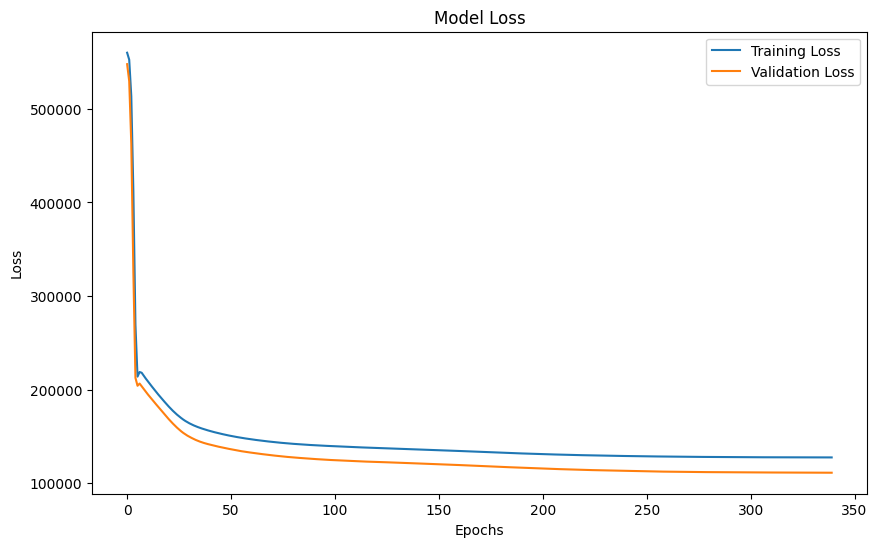

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training Loss', )
plt.plot(history.history['val_mae'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(False)
plt.show()

In [ ]:
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42960543744.0000 - mae: 123659.7188 - mse: 42960543744.0000 
Test MAE: 44126265344.0
Test MSE: 123281.4765625


# Export the Trained Model

The trained model is saved to a file using Python's `pickle` module. This allows the model to be persisted and reloaded later without the need to retrain.

* `trained_model.pkl` specifies the filename for the saved model.
* `wb` opens the file in binary write mode.
* `pickle.dump(model, file)` serializes the trained model object and writes it to the file.

This process ensures that the model's architecture and learned weights are stored in a file, making it convenient to deploy or share the model in the future.

In [ ]:
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Load the Trained Model

If we want to load the previously saved model from a file, we can use Python's `pickle` module.

* `/content/trained_model.pkl` specifies the path to the file containing the saved model.
* `rb` opens the file in binary read mode.
* `pickle.load(file)` deserializes the model object from the file, restoring the trained model for future use.

This step allows you to reload the model for evaluation, inference, or further training, without needing to retrain it from scratch.

In [ ]:
with open('/content/trained_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Prediction of a New Data Point using the Trained Model

A new data point is prepared for prediction by creating a dictionary with the required features, which is then converted into a DataFrame. The data is processed similarly to the training data:

* `create_new_features()` adds new features such as house_age and years_since_renovation.
* Bucketization and normalization: The features are bucketized and normalized according to the preprocessing steps applied to the training data.

In [ ]:
new_pred = {key:0 for key in X_train.columns}

new_pred['date'] = pd.to_datetime('2014-07-10')
new_pred['bedrooms'] = 5
new_pred['bathrooms'] = 3
new_pred['sqft_living'] = 10000
new_pred['sqft_lot'] = 1000
new_pred['floors'] = 2
new_pred['waterfront'] = 1
new_pred['view'] = 3
new_pred['condition'] = 5
new_pred['sqft_above'] = 500
new_pred['sqft_basement'] = 500
new_pred['yr_built'] = 2000
new_pred['yr_renovated'] = 2012
new_pred['city_Bellevue'] = 1

new_pred = pd.DataFrame([new_pred])
new_pred = create_new_features(new_pred)
for col, size in bucket_sizes.items():
    new_pred[col] = bucketize(new_pred, col, size)
for col in numerical_features:
    new_pred[col] = normalize(new_pred, col)

The processed data is fed into the trained model to predict the house price. The `predict` method generates the predicted price, which is then printed in a formatted manner.

This process demonstrates how to make predictions on new data using a previously trained and saved model.

In [ ]:
# Predict the price
predicted_price = loaded_model.predict(new_pred)

# Output the predicted price
print(f"Predicted house price: ${predicted_price[0][0]:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted house price: $2,399,025.25


# Developing a Web Application Based on the Trained Model

Next, we develop a web application using `streamlit`. This interface will allow users to input features and then use the trained model to predict house prices. [Here](https://huggingface.co/spaces/RMHalak/house-pricing-v1/blob/main/app.py) you can find the development of the web application.

# Deploying the Application on Hugging Face Spaces

Lastly, we can deploy the application by hosting it on a cloud service such as [Hugging Face Spaces](https://huggingface.co/spaces). This makes the model accessible via a web browser for other users.

In [ ]:
from IPython.display import HTML

html_code = '''
<iframe
    src="https://rmhalak-house-pricing-v1.hf.space/"
    frameborder="0"
    width="1200"
    height="750"
></iframe>
'''

display(HTML(html_code))